# Extend dataset using other splitters and embedders

I think that approach I have used to find relevant pictures for the dataset might have backfired: it is practically overfit to the results which are found with Instructor embeddings and 120-60 splitter. I would like to try other configurations to avoid bias

In [1]:
%load_ext dotenv
%dotenv

In [2]:
from pathlib import Path
from portrait_search.dependencies import Container
from portrait_search.embeddings.embedders import EMBEDDERS, EmbedderType
from portrait_search.embeddings.splitters import SPLITTERS, SplitterType

container = Container()
container.init_resources()

SPLITTER = SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40
EMBEDDER = EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS

container.splitter.override(SPLITTERS[SPLITTER])
container.embedder.override(EMBEDDERS[EMBEDDER])

retriever = container.retriever()
retriever.splitter, retriever.embedder

/home/tsdaemon/.cache/pypoetry/virtualenvs/portrait-search-PDxvISEv-py3.11/lib/python3.11/site-packages/InstructorEmbedding/instructor.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


load INSTRUCTOR_Transformer
max_seq_length  512


(LangChainRecursiveSplitter({'splitter': <langchain.text_splitter.RecursiveCharacterTextSplitter object at 0x7f36194c9210>, '_type': <SplitterType.LANGCHAIN_RECURSIVE_TEXT_SPLITTER_CHUNK_160_OVERLAP_40: 'langchain-recursive-text-splitter-chunk-160-overlap-40'>}),
 InstructorEmbedder({'expected_dimensionality': None, '_type': <EmbedderType.INSTRUCTOR_LARGE_PATHFINDER_CHARACTER_INSTRUCTIONS: 'instrtucor-large-pathfinder-character-instructions'>, 'instructions': 'Represents a description of a Pathfinder character:', 'model': INSTRUCTOR(
   (0): Transformer({'max_seq_length': 512, 'do_lower_case': False}) with Transformer model: T5EncoderModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False})
   (2): Dense({'in_features': 1024, 'out_features': 768, 'bias': False, 'activa

In [3]:
portraits_path = Path().absolute().parent / ".data/portraits"
portraits_path.exists()

True

Besides, manually editing config is quite boring and leads to errors. I want to make it interactive:
1. Load dataset
2. For each query, run it and get results
3. For each result, ask if it matches the query and ask to select the list of matches
4. After editing one query, validate and store results

In [4]:
from portrait_search.quality.dataset import load_dataset, store_dataset, validate_dataset, DatasetEntry, Query, PortraitMatch, yaml
from IPython import display

dataset = load_dataset("v1")
dataset

[Dataset entry: tanky. Queries: 4. Portraits: 44.,
 Dataset entry: inquisitor-hammer. Queries: 4. Portraits: 24.,
 Dataset entry: dreamy-woman. Queries: 4. Portraits: 14.,
 Dataset entry: human-druid-cleric. Queries: 4. Portraits: 21.,
 Dataset entry: man-portrait. Queries: 4. Portraits: 14.,
 Dataset entry: gnome-rogue. Queries: 3. Portraits: 15.,
 Dataset entry: red-cape-assasin. Queries: 4. Portraits: 19.,
 Dataset entry: elf-fire-blades. Queries: 3. Portraits: 14.,
 Dataset entry: brutal-warrior. Queries: 5. Portraits: 17.,
 Dataset entry: org-twohanded-rogue. Queries: 4. Portraits: 15.]

In [5]:
# Try storing it to see if it preserves formatting
store_dataset(dataset, "v1")

In [6]:
async def check_query(query: Query):
    # First check exising portraits
    for existing_portrait in query.portraits:
        display.display(display.Pretty(data=existing_portrait.path), display_id="1", clear=True)
        matches_list = '\n * '.join(existing_portrait.match)
        display.display(
            display.Pretty(f"Portrait {existing_portrait.path} already exists in query with matches: \"{matches_list}\".\nIs it correct? (y/n)"), 
            display_id="1"
        )
        match_correct_answer = input()
        display.display(display.Pretty(f"Answer: {match_correct_answer}"), display_id="1")
        match_incorrect = match_correct_answer == "n"
        if not match_incorrect:
            continue
        # remove portrait from query and add it again
        display.display(display.Pretty(f"Removing {existing_portrait}"), display_id="1")
        query.portraits.remove(existing_portrait)
    
    # Then check new potential portraits
    portraits, explanations = await retriever.get_portraits(query.query, experiment="v1")

    for portrait, explanation in zip(portraits, explanations):
        display.display(display.Pretty(data=portrait.fulllength_path), display_id="1", clear=True)
        display.display(display.Image(filename=portraits_path / portrait.fulllength_path, height=350, width=350), display_id="1")
        display.display(*[display.Pretty(data=e.to_explanation()) for e in explanation], display_id="1")

        existing_portrait = next((p for p in query.portraits if p.path == portrait.fulllength_path), None)
        if existing_portrait is not None:
            continue
        
        portrait_matches = []
        for match in query.match:
            display.display(display.Pretty(f"Is this portrait matches \"{match}\"? (y/n)"), display_id="1")
            match_confirmed_answer = input()
            display.display(display.Pretty(f"Answer: {match_confirmed_answer}"), display_id="1")
            match_confirmed = match_confirmed_answer == "y"
            if match_confirmed:
                portrait_matches.append(match)
        
        if len(portrait_matches) > 0:
            query.portraits.append(PortraitMatch(path=portrait.fulllength_path, match=portrait_matches))
        
        query.validate_entity()
        store_dataset(dataset, "v1")

# Tanky

In [7]:
dataset_entry = dataset[0]
dataset_entry

Dataset entry: tanky. Queries: 4. Portraits: 44.

In [9]:
query = dataset_entry.queries[2]
query

Query: "knight in heavy armor, two handed weapon". Query matches: "heavy armor, knight, two handed weapon". Portraits: 14.

nexusmods-pathfinderkingmaker-92-974/HE (Human, Elf, Half-Elf)/HE_Melee, Fighter/Misc/HE-MF-MS-M224/Fulllength.png

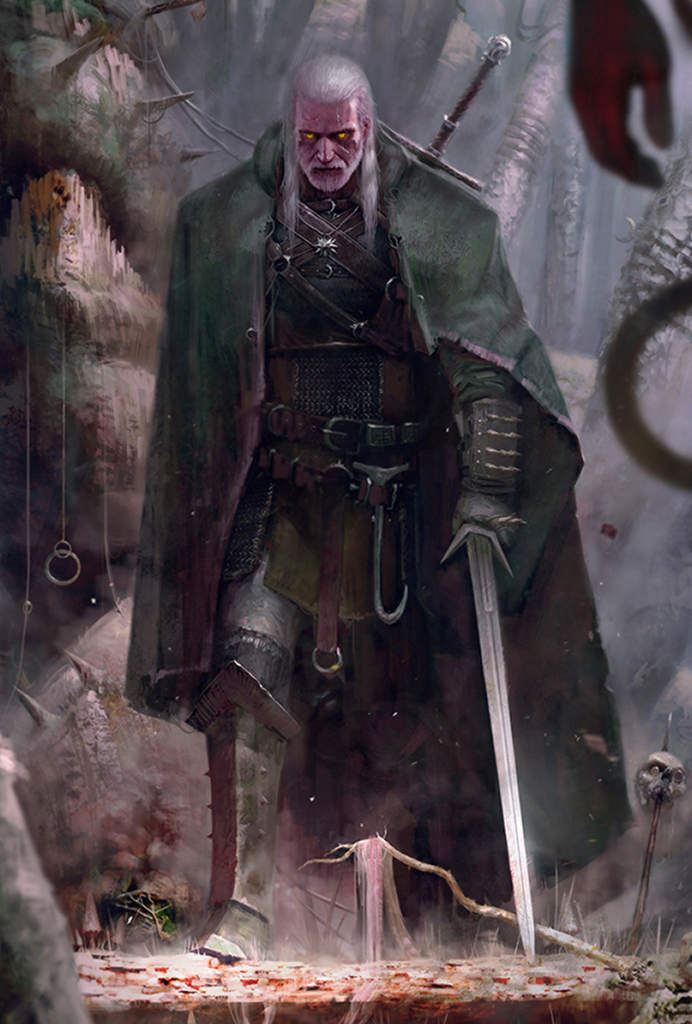

Query: knight in heavy armor, two handed weapon
Portrait text: with subclasses such as the Eldritch Knight or Hunter due to the martial look and readiness for battle. He wields a broadsword, a weapon signifying a
Similarity: 0.09833186864852905

Is this portrait matches 'heavy armor'? (y/n)

In [10]:
await check_query(query)